In [7]:
"""
load data
"""
import sklearn.datasets
import numpy as np
import random

iris = sklearn.datasets.load_iris()
data = iris['data']
labels = iris['target']

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
def plot_matrix(x, y, group, fmt='.', **kwargs):
    """
    Given two d-dimensional datasets of n points,
    makes a figure containing d x d plots, where the (i, j) plot
    plots the ith dimension against the jth dimension.
    """

    x = np.asarray(x)
    y = np.asarray(y)
    group = np.squeeze(np.asarray(group))
    n, p = x.shape
    n_, q = y.shape
    n__, = group.shape
    assert n == n_ == n__
    groups = sorted(set(group))
    if isinstance(fmt, str):
        fmt = {k: fmt for k in groups}
    fig, axes = plt.subplots(p, q, squeeze=False, **kwargs)
    for i, axrow in enumerate(axes):
        for j, ax in enumerate(axrow):
            for g in groups:
                ax.plot(x[group == g, i], y[group == g, j], fmt[g])
            if len(axes) > 2:
                ax.locator_params(tight=True, nbins=4)

def plot_groups(x, group, fmt='.', **kwargs):
    """
    Helper function for plotting a 2-dimensional dataset with groups
    using plot_matrix.
    """
    n, d = x.shape
    assert d == 2
    x1 = x[:, 0].reshape(n, 1)
    x2 = x[:, 1].reshape(n, 1)
    plot_matrix(x1, x2, group, fmt, **kwargs)

In [ ]:
def closest(data, centers):
    n, d = data.shape
    k, d_ = centers.shape
    assert d == d_
    
    rep = np.zeros(n,)
    for i in range(n):
        distance = np.sum(np.sqrt((data[i] - centers)**2), axis = 1)
        rep[i] = np.argmin(distance)
        
    assert rep.shape == (n,)
    assert np.all((0 <= rep) & (rep < k))
    rep = rep.astype('int')
    return rep


def kmeans_cost(data, centers, rep):
    n, d = data.shape
    k, d_ = centers.shape
    assert d == d_
    assert rep.shape == (n,)
    data_rep = centers[rep]
    cost = 0
    for i in range(n):
        cost += np.sum((data[i] - data_rep[i])**2)
    return cost

"""
K-means clustering algorithm
args:
D = dataset
k = number of clusters
epsilon = convergence threshold
"""

def k_means(D, k, epsilon, verbose = True):
    n,d = D.shape
    print("start")
    """
    init random centroids
    centroids is a k,d array where element i,j is the jth value of the ith centroid
    assign each data point to a closest centroid
    recaulculate clusters as mean of all elements in cluster
    if cluster is empty, reassign randomly.
    calculate distance between new and old clusters
    if distance is smaller than epsilon, terminate
    """
    maximum = np.amax(D, axis = 0)
    minimum = np.amin(D, axis = 0)
    centers = np.zeros((k,d))
    for i in range(len(centers)):
        for j in range(d):
            centers[i,j] = random.uniform(minimum[j], maximum[j])
    old_centers = np.zeros_like(centers)
    tired = False
    
    while not tired:
        old_centers[:] = centers
        rep = closest(D, centers)
        for i in range(k):
            indices = np.where(rep == i)[0]
            if len(indices) == 0:
                   for j in range(d):
                       print('tom')
                       centers[i,j] = random.uniform(minimum[j], maximum[j])
            else:
                centers[i] = np.sum(D[indices], axis = 0)/len(indices)
            
        dist = np.sqrt(((centers - old_centers) ** 2).sum(axis=1))
        tired = np.max(dist) <= epsilon
        cost = kmeans_cost(D, centers, rep)
        if verbose == True:
            print(cost)
    return centers, rep, cost

def k_means_opt(D, k, epsilon, n):
    centers = []
    rep = []
    cost = []
    for i in range(n):
        res = k_means(D, k, epsilon, verbose = False)
        centers.append(res[0])
        rep.append(res[1])
        cost.append(res[2])
    j = np.argmin(cost)
    return centers[j], rep[j], cost[j]

In [43]:
data_2d = data[:, 1:3]
#centers, rep, cost = k_means_opt(data_2d, 3, 1e-4, 50)

centers, rep, cost = k_means(data_2d, 3, 1e-3)

97.7071302178
59.6898050656
44.4346494325
43.5710256304
42.7347971014
41.8794
41.6635242874
41.9343284374
41.5894269294
41.522989071
41.522989071


[[             nan              nan]
 [ -2.84217094e-15  -8.40808904e-16]
 [             nan              nan]]


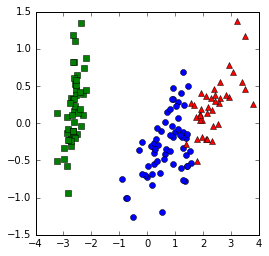

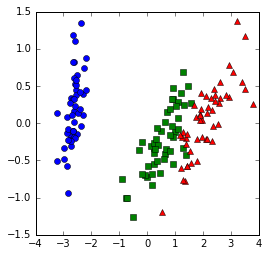

In [26]:
print(centers)
plot_groups(data_pca, rep, {0: 'o', 1: 's', 2: '^'}, figsize=(4, 4))
plot_groups(data_pca, labels, {0: 'o', 1: 's', 2: '^'}, figsize=(4, 4))


In [62]:
from scipy.stats import multivariate_normal
def pdf(points, mean, cov, prior):
    points, mean, cov = np.asarray(points), np.asarray(mean), np.asarray(cov)
    prior = np.asarray(prior)
    n, d = points.shape
    k, d_1 = mean.shape
    k_2, d_2, d_3 = cov.shape
    k_3, = prior.shape
    assert d == d_1 == d_2 == d_3
    assert k == k_2 == k_3, "%s %s %s should be equal" % (k, k_2, k_3)

    # Compute probabilities
    prob = []
    for i in range(k):
        if prior[i] < 1 / k ** 3:
            prob.append(np.zeros(n))
        else:
#            print("pdf mean ",mean[i])
#            print("pdf cov ",cov[i])
            prob.append(
                prior[i] *
                multivariate_normal.pdf(
                    mean=mean[i], cov=cov[i], x=points,allow_singular=False))
    prob = np.transpose(prob)  # n x k
    # Normalize cluster probabilities of each point
    prob = prob / np.sum(prob, axis=1, keepdims=True)  # n x k

    assert prob.shape == (n, k)
    assert np.allclose(prob.sum(axis=1), 1)
    return prob

def most_likely(points, mean, cov, prior):
    prob = pdf(points, mean, cov, prior)
    return np.argmax(prob, axis=1)

def em(points, k, epsilon, mean=None):
    points = np.asarray(points)
    n, d = points.shape

    # Initialize and validate mean
    if mean is None:
        # Randomly pick k points
        maximum = np.amax(points, axis = 0)
        minimum = np.amin(points, axis = 0)
        mean = np.zeros((k,d))
        for i in range(k):
            for j in range(d):
                mean[i,j] = np.random.uniform(minimum[j], maximum[j])

    # Validate input
    mean = np.asarray(mean)
    k_, d_ = mean.shape
    assert k == k_
    assert d == d_

    # Initialize cov, prior
    cov = np.array([np.eye(d) for x in range(k)])
    prior = np.array([1/k for x in range(k)])

    tired = False
    t = 0
    old_mean = np.zeros_like(mean)
    while not tired:
        t += 1
        old_mean[:] = mean

        # Expectation step
 #       print("--------------------------------")
 #       print("Emean ",mean)
 #       print("Ecov ",cov)
 #       print("Eprior ",prior)
        weights=pdf(points, mean, cov, prior)
 #       print ("weights ",weights)
        # Maximization step
        weights_sum=np.sum(weights,axis=0)
 #       print("sum",weights_sum)
        for i in range(k):
            res=weights[:,i].reshape(n,1)*points
            mean[i]=np.sum(res,axis=0)/weights_sum[i]
            new_cov=np.zeros([d,d])
            for j in range(n):
                new_cov+=weights[j,i]*np.outer(points[j]-mean[i],points[j]-mean[i])
            cov[i]=new_cov/weights_sum[i]
        prior[:]=weights_sum/n    
                    

        # Finish condition
        dist = np.sqrt(((mean - old_mean) ** 2).sum(axis=1))
        tired = np.all(dist < epsilon)
    print("HURTIG")
    # Validate output
    assert mean.shape == (k, d)
    assert cov.shape == (k, d, d)
    assert prior.shape == (k,)
    print(t)
    return mean, cov, prior

def em_langsom(points, k, epsilon, mean=None):
    points = np.asarray(points)
    n, d = points.shape

    # Initialize and validate mean
    if mean is None:
        # Randomly pick k points
        maximum = np.amax(points, axis = 0)
        minimum = np.amin(points, axis = 0)
        mean = np.zeros((k,d))
        for i in range(k):
            for j in range(d):
                mean[i,j] = np.random.uniform(minimum[j], maximum[j])

    # Validate input
    mean = np.asarray(mean)
    k_, d_ = mean.shape
    assert k == k_
    assert d == d_

    # Initialize cov, prior
    cov = np.array([np.eye(d) for x in range(k)])
    prior = np.array([1/k for x in range(k)])

    tired = False
    old_mean = np.zeros_like(mean)
    while not tired:
        old_mean[:] = mean

        # Expectation step
        print("--------------------------------")
        print("Emean ",mean)
 #       print("Ecov ",cov)
 #       print("Eprior ",prior)
        weights=pdf(points, mean, cov, prior)
 #       print ("weights ",weights)
        # Maximization step
        weights_sum=np.sum(weights,axis=0)
 #       print("sum",weights_sum)
        for i in range(k):
            weight_sum_s=0
            for j in range(n):
                weight_sum_s+=weights[j,i]
            mean_sum=np.zeros(d)
 #           print(mean_sum)
            for j in range(n):
                mean_sum+=weights[j,i]*points[j]
            mean[i]=mean_sum/weight_sum_s
#            print(" ny mean ",mean)
            cov_slow=np.zeros([d,d])
            for j in range(n):
                diff=points[j]-mean[i]
 #               print("diff ",diff,diff.reshape((d,1)))
                dotprodukt=np.outer(diff.reshape(d,1),diff.reshape(1,d))
 #               print("dotprukt ",dotprodukt)
                cov_slow+=weights[j,i]*dotprodukt
            cov[i]=cov_slow/weight_sum_s
            np.linalg.pinv(cov[i])
            
            prior[i]=weight_sum_s/n
 #           res=weights[:,i].reshape(n,1)*points
 #           print("hurtig mean ",np.sum(res,axis=0)/weights_sum[i])
 #           new_cov=np.zeros([d,d])
 #           for j in range(n):
 #               new_cov+=weights[j,i]*np.outer(points[j]-mean[i],points[j]-mean[i])
 #           cov[i]=new_cov/weights_sum[i]
 #       prior[:]=weights_sum/n    
                    
 #       print ("prior ",prior)
 #       print("mean ",mean)
 #       print("cov ",cov)
 #       print("----------------------------------------")
        
        # Finish condition
        dist = np.sqrt(((mean - old_mean) ** 2).sum(axis=1))
        tired = np.all(dist < epsilon)
 #       tired=True

    # Validate output
    assert mean.shape == (k, d)
    assert cov.shape == (k, d, d)
    assert prior.shape == (k,)
    return mean, cov, prior

158.561906361
131.020649276
130.189486417
128.757490235
128.15845901
127.866214767
127.761603789
127.791989958
127.791989958
[[ 1.40541808 -0.05731672]
 [-2.57235031  0.48369717]
 [-2.40623444 -0.3753546 ]]
HURTIG
RESULTAT:
[[ 1.32040118 -0.09526373]
 [-2.64662275  0.33313681]
 [-2.63658826  0.08572907]]
[[[ 1.04067285  0.34940977]
  [ 0.34940977  0.22635983]]

 [[ 0.01162171  0.04331776]
  [ 0.04331776  0.29691257]]

 [[ 0.07429341  0.06620899]
  [ 0.06620899  0.12837853]]]
[ 0.66666974  0.14119748  0.19213279]
300


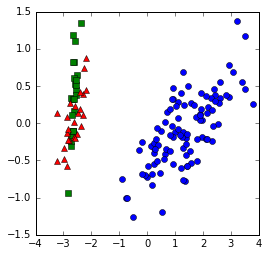

In [36]:
import sklearn.datasets
import sklearn.decomposition
tmean=np.array([[2.307,0.29],[0.66,-0.35],[-2.64,0.19]])
pca = sklearn.decomposition.PCA(2)
data_pca = pca.fit_transform(data)

centers, rep, cost = k_means(data_pca, 3, 1e-4)
print(centers)
rmean,rcov,rprior=em(data_pca,3,1e-04,mean= centers)
print ("RESULTAT:")
print(rmean)
print(rcov)
print(rprior)
print(data_pca.size)
cluster=most_likely(data_pca,rmean,rcov,rprior)

#############
import sklearn.mixture as skm
ft = skm.GaussianMixture(n_components = 3)
test = ft.fit(data_pca)

#############
plot_groups(data_pca,cluster,{0:'o',1:'s',2:'^'},figsize=(4,4))

tom
tom
tom
tom
tom
tom
tom
tom
--------------------------------
Emean  [[ 6.87027027  3.08648649  5.74594595  2.08918919]
 [ 5.9047619   2.74603175  4.41269841  1.43333333]
 [ 5.006       3.418       1.464       0.244     ]]
--------------------------------
Emean  [[ 6.67583171  3.010736    5.47215197  1.93608482]
 [ 5.96498069  2.77741549  4.4949172   1.48543402]
 [ 5.01190919  3.39256814  1.5164026   0.26656296]]
--------------------------------
Emean  [[ 6.69008196  3.01090507  5.52521531  1.9686964 ]
 [ 5.9578994   2.77332488  4.46612218  1.46807189]
 [ 5.00600175  3.41798997  1.46402028  0.24401051]]
--------------------------------
Emean  [[ 6.70234057  3.00795567  5.58798046  2.00547302]
 [ 5.96402875  2.78000102  4.4445149   1.453051  ]
 [ 5.00600007  3.41800014  1.46400002  0.24399999]]
--------------------------------
Emean  [[ 6.70579096  3.00500791  5.63088893  2.03421545]
 [ 5.96405143  2.78270229  4.41933027  1.43550439]
 [ 5.00600002  3.41800004  1.46400001  0.244     ]

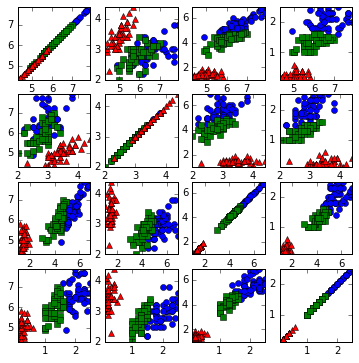

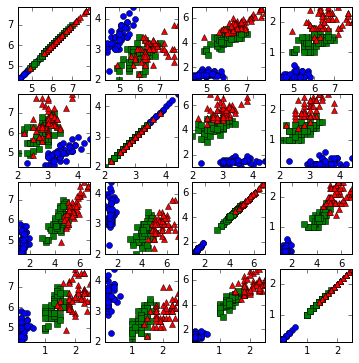

In [68]:
# 4d data
centers, rep, cost = k_means_opt(data, 3, 1e-4, n = 50)
rmean,rcov,rprior=em_langsom(data,3,1e-04,mean= centers)
cluster=most_likely(data,rmean,rcov,rprior)
print(centers)
print(rmean)

plot_matrix(data, data, cluster, {0: 'o', 1: 's', 2: '^'}, figsize = (6,6))
plot_matrix(data, data, labels, {0: 'o', 1: 's', 2: '^'}, figsize = (6,6))

24608.4418907
13556.8305022
11044.7424685
9699.63983704
8951.90419091
8507.28771034
8228.00495845
8052.25556583
7933.75974316
7856.18573103
7804.02260721
7763.24584516
7734.67376025
7714.35866071


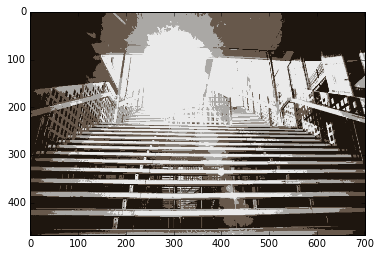

In [77]:
import scipy.misc

def download_image(url):
    filename = url[url.rindex('/')+1:]
    try:
        with open(filename, 'rb') as fp:
            return scipy.misc.imread(fp) / 255
    except FileNotFoundError:
        import urllib.request
        with open(filename, 'w+b') as fp, urllib.request.urlopen(url) as r:
            fp.write(r.read())
            return scipy.misc.imread(fp) / 255

img_facade = download_image('https://users-cs.au.dk/rav/ml/handins/h4/nygaard_facade.jpg')
img_stairs = download_image('https://users-cs.au.dk/rav/ml/handins/h4/nygaard_stairs.jpg')

def compress_kmeans(im, k=4):
    height, width, depth = im.shape

    data = im.reshape((height * width, depth))
    centers, rep, cost = k_means(data, k, 1e-2)
    rep = closest(data, centers)
    data_compressed = centers[rep]

    im_compressed = data_compressed.reshape((height, width, depth))
    plt.figure()
    plt.imshow(im_compressed)
    plt.show()

def compress_facade(k=4):
    print("sss")
    img_facade = download_image('https://users-cs.au.dk/rav/ml/handins/h4/nygaard_facade.jpg')
    compress_kmeans(img_facade, k=k)

def compress_stairs(k=4):
    img_stairs = download_image('https://users-cs.au.dk/rav/ml/handins/h4/nygaard_stairs.jpg')
    compress_kmeans(img_stairs, k=k)
    
compress_kmeans(img_stairs)

tom
tom
tom
tom
tom
tom
394.35308554
tom
tom
tom
217.810406629
178.2743416
165.19614656
155.10396799
146.706804563
141.350266008
138.032631224
136.147439574
134.102789067
132.693323855
131.260367445
130.499912633
129.568203593
128.911440061
128.225691417
127.86783061
127.623342549


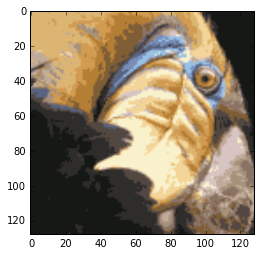

In [80]:
img_bird = download_image('https://lh3.googleusercontent.com/HtDi8G85X9kK798dfesFI0YKbQeOF_WuHM1ktqw3pNA9N-Mvx0jXoLU3qew4ykAvBafFnhJBG7uuTGg=w1301-h654')
compress_kmeans(img_bird, k = 16)